## Imports

In [409]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label

## Retrieve Images

In [387]:
def getImageFilesFromDirectory(directory):
    images = []   
    for imageFile in os.listdir(directory):
        if not imageFile[0] == '.':
            images.append(directory + '/' + imageFile)   
    return images

def displayImages(images):
    if len(images) == 1:
        showImage(images[0],plt)
        return
    
    plt.figure
    f, axarr = plt.subplots(1,len(images))
    for i in range(len(images)):
        showImage(images[i],axarr[i],multiple=True)
        
def showImage(image,obj,multiple=False):
    if not multiple:
        obj.figure()
    if len(image.shape) == 2: 
        color='gray'
    else:
        color=None
    obj.imshow(image, cmap=color)

In [331]:
image = mpimg.imread('training data/vehicles/KITTI_extracted/1.png')
print('Train image shape: ',image.shape)

Train image shape:  (64, 64, 3)


## Feature Parameters

In [332]:
class featureParams():
    def __init__(self):
        # HOG
        self.channel = 2
        self.orient = 9
        self.pix_per_cell = 9
        self.cell_per_block = 2
        
        # color spatial
        self.colorSpace = 'RGB'
        self.spatial_size = (32, 32)
        
        # color histogram
        self.hist_bins = 32
        self.hist_range = (0,256)
    
params = featureParams()

## HOG

In [333]:
def HOGfeatures(image, params, debug=False):
    singleChannelImage = image[:,:,params.channel]
    feature_array, feature_image = hog(singleChannelImage, 
                        orientations = params.orient, 
                        pixels_per_cell = (params.pix_per_cell, params.pix_per_cell), 
                        cells_per_block = (params.cell_per_block, params.cell_per_block), 
                        visualise=True, 
                        feature_vector=False)
    if debug:
        displayImages([feature_image, singleChannelImage])
    
    return feature_array

def ravelHOGfeatures(HOGfeatures, startX, startY, xLength=7, yLength=7):
    subset = HOGfeatures[startX:startX+xLength,startY:startY+yLength,:,:,:]
    return np.ravel(subset)

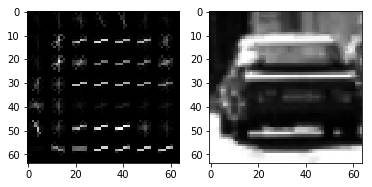

In [388]:
image = mpimg.imread('training data/vehicles/KITTI_extracted/1.png')
image = colorTransform(image, "HSV")
HOGfeatures(image, params, debug=True)
print()

## Color

In [342]:
def colorTransform(image, color):
    transform = eval('cv2.COLOR_RGB2' + color)
    return cv2.cvtColor(image, transform)

In [343]:
def spatialColorFeatures(image, params):
    features = cv2.resize(image, params.spatial_size).ravel() 
    return features

In [344]:
def histoColorFeatures(image, params):
    hist_features = []
    for i in range(image.shape[2]):
        channel_hist = np.histogram(image[:,:,i], bins=params.hist_bins, range=params.hist_range)
        hist_features = np.concatenate((hist_features, channel_hist[0])).astype(int)
    return hist_features

## Feature Extractor

In [379]:
def getFeaturesFromFiles(imageFiles, params):
    
    features = []
    for imageFile in imageFiles:
        image = mpimg.imread(imageFile)
        
        features.append(getFeaturesFromImage(image, params))
    return features

def getFeaturesFromImage(image, params):
    if params.colorSpace != 'RGB':
        image = colorTransform(image, params.colorSpace)

    spatial_features = spatialColorFeatures(image, params)
    hist_features = histoColorFeatures(image, params)
    HOG_features = HOGfeatures(image, params)
    HOG_features = ravelHOGfeatures(HOG_features, 0, 0)
    
    return np.concatenate((spatial_features, hist_features, HOG_features))

In [375]:
getFeatures(['training data/vehicles/KITTI_extracted/1.png'], params)

[array([1.41176477e-01, 1.47058830e-01, 1.67647064e-01, ...,
        1.57815245e-04, 0.00000000e+00, 1.02911760e-03])]

## Train Classifier

In [347]:
cars = getImageFilesFromDirectory('training data/vehicles/KITTI_extracted')
notCars = getImageFilesFromDirectory('training data/non-vehicles/Extras')

carFeatures = getFeaturesFromFiles(cars, params)
notCarFeatures = getFeaturesFromFiles(notCars, params)

X = np.vstack((carFeatures, notCarFeatures)).astype(np.float64)
y = np.hstack((np.ones(len(carFeatures)), np.zeros(len(notCarFeatures))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [359]:
X[0].shape

(4464,)

In [350]:
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy_score(svc.predict(X_test), y_test)

0.9941096511101042

## Define the windows to look at

In [319]:
def draw_boxes(image, boxes, color=(0, 0, 255), thick=6):
    imagecopy = np.copy(image)
    for box in boxes:
        cv2.rectangle(imagecopy, (box[0][0], box[0][1]), (box[1][0], box[1][1]), color, thick)
    return imagecopy

def slide_window(image, x_start_stop=[0, None], y_start_stop=[0, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[1] == None:
        x_start_stop[1] = image.shape[1]
    if y_start_stop[1] == None:
        y_start_stop[1] = image.shape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int(np.ceil((xspan-nx_buffer)/nx_pix_per_step)) 
    ny_windows = np.int(np.ceil((yspan-ny_buffer)/ny_pix_per_step)) 
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append([(startx, starty), (endx, endy)])
    # Return the list of windows
    return window_list

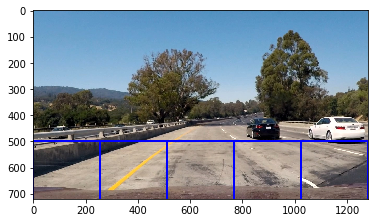

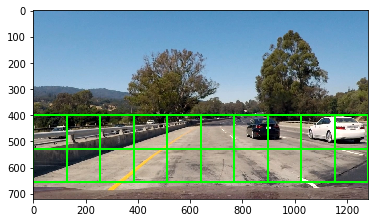

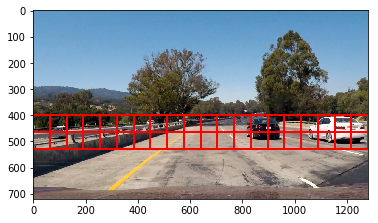

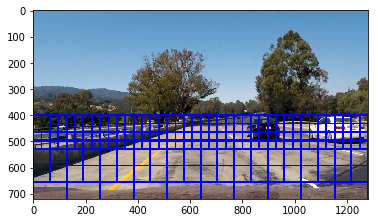

In [404]:
image = mpimg.imread('test_images/test1.jpg')

def getWindows(image, debug=False):
    windowRanges = []
    windowRanges.append({'yRange' : [500,None],
                         'xy_window' : [256, 256],
                         'color' : (0, 0, 255)})
    windowRanges.append({'yRange' : [400,600],
                         'xy_window' : [128, 128],
                         'color' : (0, 255, 0)})
    windowRanges.append({'yRange' : [400,500],
                         'xy_window' : [64, 64],
                         'color' : (255, 0, 0)})

    windows = []

    for windowRange in windowRanges:
        boxes = slide_window(image,
                             y_start_stop=windowRange['yRange'], 
                             xy_window=windowRange['xy_window'],
                             xy_overlap=(0.5, 0.5))
        if windows == []:
            windows = boxes
        else:
            windows = np.concatenate((windows, boxes))

        if debug:
            #visualize the size of the boxes
            boxes = slide_window(image,
                             y_start_stop=windowRange['yRange'], 
                             xy_window=windowRange['xy_window'],
                             xy_overlap=(0, 0))
            displayImages([draw_boxes(image, boxes, color=windowRange['color'])])
        
    return windows

image = mpimg.imread('test_images/test1.jpg')
windows = getWindows(image, True)
displayImages([draw_boxes(image, windows)])

In [405]:
def getFeaturesForWindow(image, HOGfeatures, window, params):
    
    if params.colorSpace != 'RGB':
        image = colorTransform(image, params.colorSpace)

    spatial_features = spatialColorFeatures(image, params)
    hist_features = histoColorFeatures(image, params)
    HOG_features = ravelHOGfeatures(HOGfeatures, window[0][0], window[0][1])

    features = []
    features.append(np.concatenate((spatial_features, hist_features, HOG_features)))
    return features

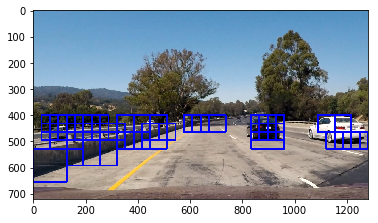

In [406]:
image = mpimg.imread('test_images/test1.jpg')

carWindows = []
#HOG_features = HOGfeatures(image, params)
for window in windows:
    imagePiece = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]],
                          (64, 64))      
    
    features = getFeaturesFromImage(imagePiece, params)
    features = X_scaler.transform(np.array(features).reshape(1, -1))
    
    if svc.predict(features) == 1:
        carWindows.append(window)
        
displayImages([draw_boxes(image, carWindows)])

## Heat map

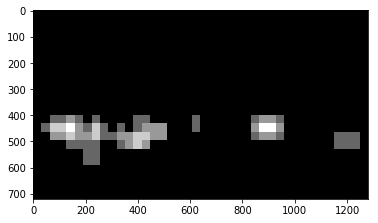

In [414]:
def add_heat(heatmap, boxes):
    for box in boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,carWindows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

displayImages([heatmap])